In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn import manifold, metrics
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, SGDClassifier, ElasticNet, RidgeClassifier, Lasso
from matplotlib.pyplot import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from numpy import mean, std
from sklearn.metrics import f1_score, r2_score
from numpy import sqrt,mean,absolute
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# import packages for hyperparameters tuning
!pip install hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# California House Prices Prediction Project

Authors: Ashritha Eswaran (ashrithe), Ishita Malhotra (ishitam), Jie Sing Yoo (jiesingy)

## Loading in Dataset

In [ ]:
df = pd.read_csv(r"C:/Users/ashri/OneDrive/Desktop/38615/FinalProject/1553768847-housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY,342200


## EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   ocean_proximity     20640 non-null  object 
 9   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


### Label Encoding

In [ ]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
# encode categories as <1h ocean = 0, inland = 1, near ocean = 2, near bay = 3, island = 4
df["ocean_proximity"] = df["ocean_proximity"].map({"<1H OCEAN":0, "INLAND":1, "NEAR OCEAN":2, "NEAR BAY":3, "ISLAND":4})
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,3,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,3,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,3,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,3,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,3,342200


### Handling Null Values

In [ ]:
# check for null values
df[df.columns[df.isnull().any()]].isnull().sum()
# total_bedrooms has 207 null values

total_bedrooms    207
dtype: int64

In [ ]:
df_nobed = df[df.total_bedrooms.isna()]

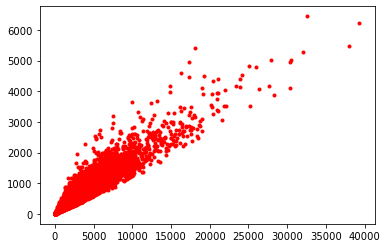

In [ ]:
#Of those with total bedrooms, is there a correlation with another variable?
df_bed = df[df.total_bedrooms.notna()]
df_bed.reset_index(inplace=True)
room = np.array(df_bed['total_rooms'])
bedrooms = np.array(df_bed['total_bedrooms'])

plt.plot(room, bedrooms, linestyle='',marker='.',color='red')
plt.show()

There is a linear relationship between rooms and number of bedrooms. Therefore, we will use a linear regression model to train and fill in the NaN values in the total_bedrooms column.

In [ ]:
room = room.reshape(-1,1)
room_bed_model = LinearRegression().fit(room,bedrooms)
print(room_bed_model.coef_, room_bed_model.intercept_)

[0.17940488] 64.86881686430712


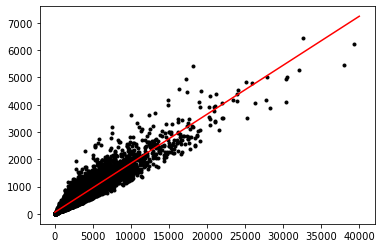

In [ ]:
xline = np.arange(40000)
yline = room_bed_model.coef_[0]*xline + room_bed_model.intercept_

plt.plot(room, bedrooms, linestyle='',marker='.',color='black')
plt.plot(xline, yline,marker='',color='red')
plt.show()

In [ ]:
val_bed = room_bed_model.predict(df[df.total_bedrooms.isna()].total_rooms.values.reshape(-1,1))
val_bed = np.around(val_bed,0)
# replace all the null values by values predicted values from ML model
nobed_ind = df[df.total_bedrooms.isna()].index
for i in range(len(nobed_ind)):
    df.loc[df.index==nobed_ind[i],'total_bedrooms'] = val_bed[i]

In [ ]:
df[df.columns[df.isnull().any()]].isnull().sum()
# no more null values

Series([], dtype: float64)

## Feature Engineering

In [ ]:
df['median_house_value']=df['median_house_value']/1000
df.rename(columns={"median_house_value": "median_house_value(in 1000s)"}, inplace=True)

In [ ]:
features = df.iloc[:, 0:-1]
features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,3
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,3
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,3
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,3
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,3


In [ ]:
target = pd.DataFrame(df.iloc[:, -1])
target.head()

,median_house_value(in 1000s)
0,452.6
1,358.5
2,352.1
3,341.3
4,342.2


In [ ]:
# Correlation table
corr_table = features.corr().abs()

<AxesSubplot:>

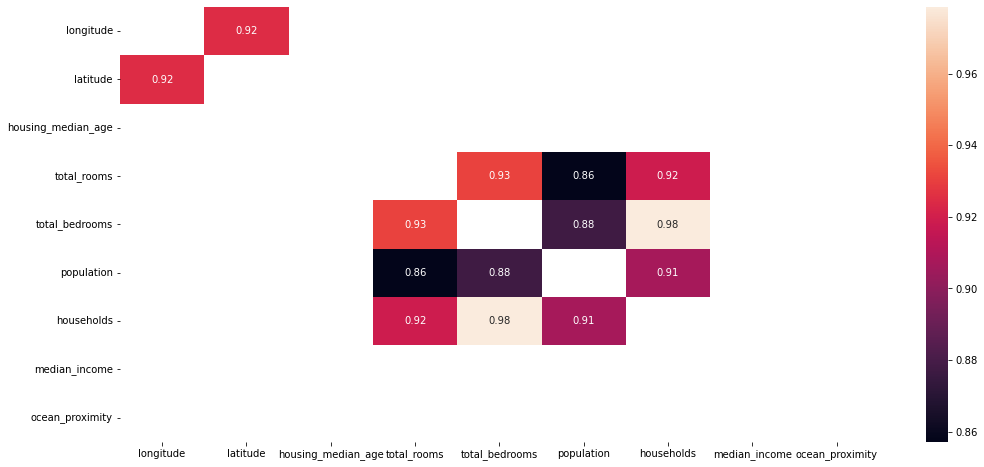

In [ ]:
# Highly correlated columns
plt.figure(figsize = (17,8))
sns.heatmap(corr_table[(corr_table >0.7)&(corr_table<1)], annot = True)

In [ ]:
# unstacking and making one column for all values of correlation 
correlation_vars = corr_table.unstack().sort_values(ascending = False).drop_duplicates()
print(correlation_vars.head())

longitude    longitude         1.000000
households   total_bedrooms    0.978644
total_rooms  total_bedrooms    0.930799
latitude     longitude         0.924664
households   total_rooms       0.918484
dtype: float64


In [ ]:
corr_columns = correlation_vars[correlation_vars>0.7].reset_index()
corr_columns.drop(0, inplace = True)
corr_columns

,level_0,level_1,0
1,households,total_bedrooms,0.978644
2,total_rooms,total_bedrooms,0.930799
3,latitude,longitude,0.924664
4,households,total_rooms,0.918484
5,households,population,0.907222
6,population,total_bedrooms,0.877380
7,population,total_rooms,0.857126


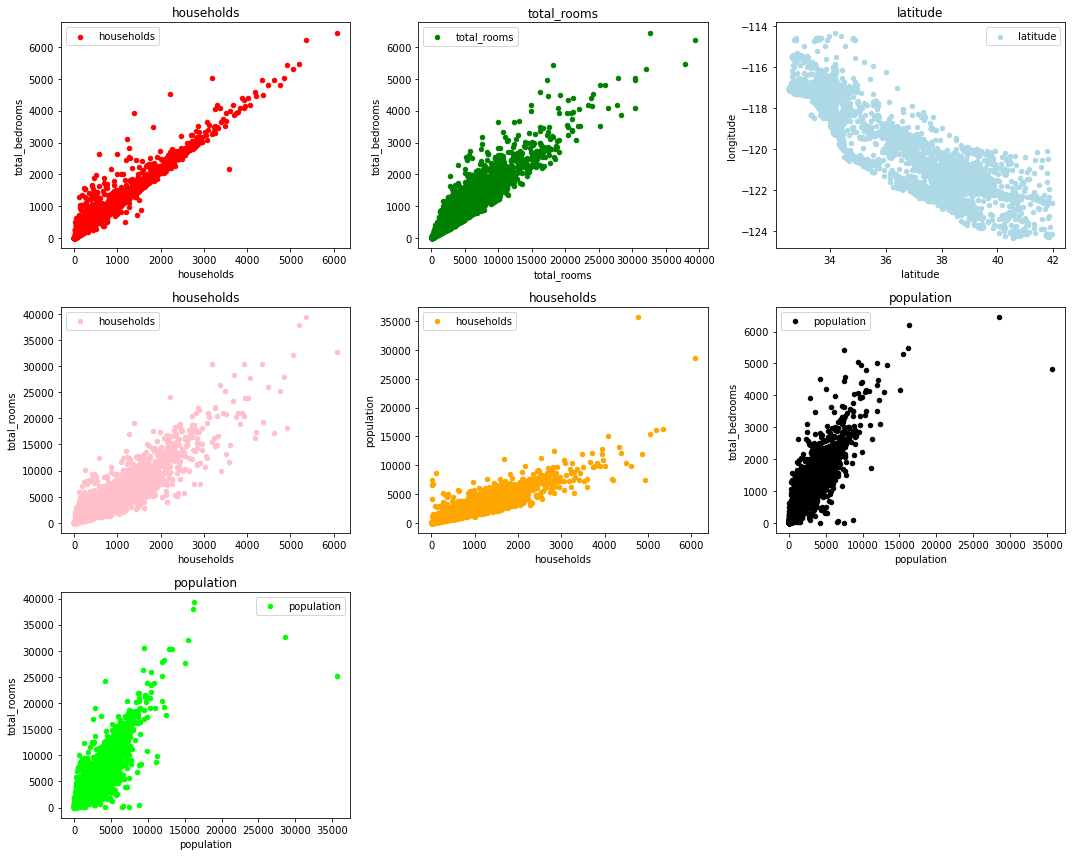

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12)) 
axes = axes.ravel()  # flattening the matrix for axes
cols = corr_columns['level_0']
cols_1 = corr_columns['level_1']
color = ['r', 'g','lightblue', 'pink','orange', 'black', 'lime']

for col,col_1, ax, color in zip(cols, cols_1, axes, color): 
    features.plot(kind='scatter',x = col, y = col_1, ax=ax, color = color, label=col, title=col)
    ax.legend() 
    
fig.delaxes(axes[7]) 
fig.delaxes(axes[8]) 
fig.tight_layout()
plt.show()

From the plots, we can see that some features have high correlation. Hence, we should drop some of them to avoid multicollinearity. Another approach we thought of is the following: create a third column from highly correlated columns and then drop both of the highly correlated columns.

In [ ]:
for a in range(1,8):
    print('{a_1}  and {a_2} has {a_3} collinearity'.format(a_1 =corr_columns['level_0'][a],
                                                           a_2 = corr_columns['level_1'][a],
                                                           a_3 = round(corr_columns[0][a],2)))

households  and total_bedrooms has 0.98 collinearity
total_rooms  and total_bedrooms has 0.93 collinearity
latitude  and longitude has 0.92 collinearity
households  and total_rooms has 0.92 collinearity
households  and population has 0.91 collinearity
population  and total_bedrooms has 0.88 collinearity
population  and total_rooms has 0.86 collinearity


It's interesting to see how latitude and longitude have high correlation. This could imply that location is an important feature in predicting house prices.

In [ ]:
## 3 New Features to Drop Highly Correlated Ones
features['rooms_per_household'] = (features['total_rooms']/features['households']).round()
features['people_per_family'] = (features['population']/features['households']).round()
features['bedrom_per_house'] = (features['total_rooms']/features['total_bedrooms']).round()

In [ ]:
#Dropping Highly Correlated Features
features.drop(['total_rooms', 'total_bedrooms', 'population', 'households'], axis = 1,inplace=True)

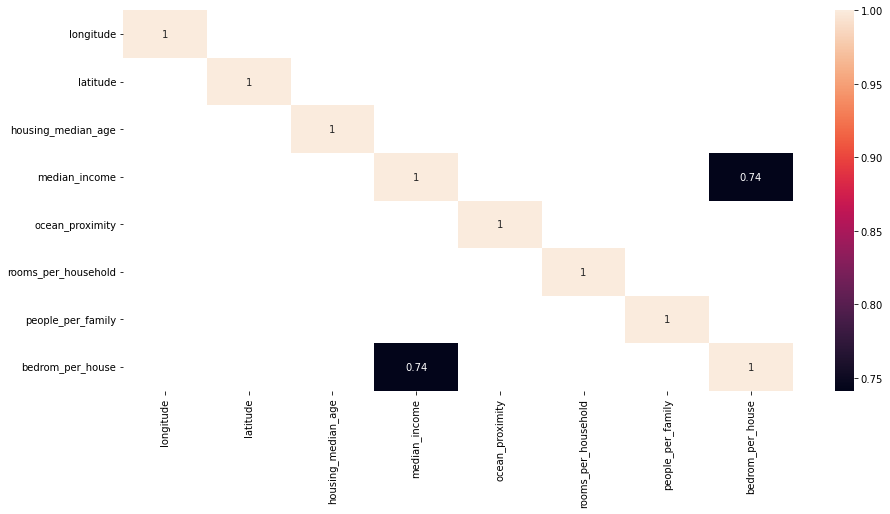

In [ ]:
#Checking to see if newly added columns have high correlation
cor_df = features.corr()
plt.figure(figsize = (15,7))
sns.heatmap(cor_df[cor_df>0.7], annot = True)
plt.show()

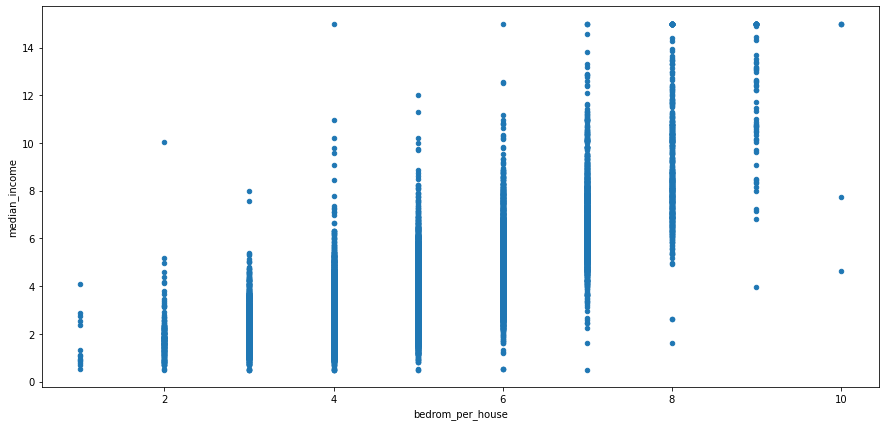

In [ ]:
# see the correlation between bedrom_per_house and median_income
features.plot(kind ='scatter', x = 'bedrom_per_house', y = 'median_income', figsize = (15,7)) 
plt.show()

In [ ]:
#StandardScaler
sc = StandardScaler()
scaled_features = sc.fit_transform(features)

## Model Building

### Train Test Split

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit 
x_train, x_test, y_train, y_test =  train_test_split(scaled_features,target,test_size=.3, random_state=0)

In [ ]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(6192, 8)
(6192, 1)
(14448, 8)
(14448, 1)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

### Linear Regression

In [ ]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
linreg.score(x_train, y_train)

0.6151429144160314

In [ ]:
y_pred = linreg.predict(x_test)

In [ ]:
#squared_root_of_mean_squared_error tells that the predictions interval, the lower, the better
np.sqrt(mean_squared_error(y_test, y_pred)) 

73.27148074815203

In [ ]:
# r2 tells that how much the function can be explained by our model, the higher r2, the better
r2_score(y_test, y_pred)

0.5973176029089209

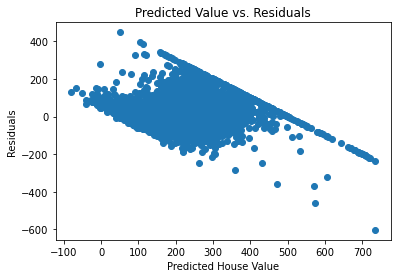

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Predicted Value vs. Residuals')
plt.xlabel('Predicted House Value')
plt.ylabel('Residuals')
plt.show()

### XGBoost Regressor

In [ ]:
!pip install xgboost
import xgboost as xgb

In [ ]:
xg = xgb.XGBRegressor()
xg.fit(x_train, y_train)
xg.score(x_train, y_train)

0.9261117211827349

In [ ]:
y_x_hat = xg.predict(x_test)

In [ ]:
print(np.sqrt(mean_squared_error(y_test, y_x_hat)))
print(r2_score(y_test, y_x_hat))

47.12679279393119
0.8334178440858632


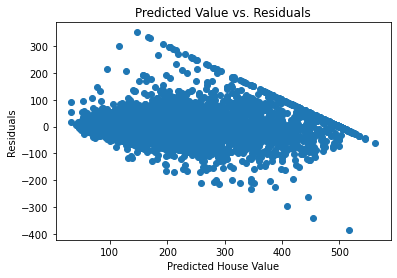

In [ ]:
residuals = y_test['median_house_value(in 1000s)'] - y_x_hat
plt.scatter(y_x_hat, residuals)
plt.title('Predicted Value vs. Residuals')
plt.xlabel('Predicted House Value')
plt.ylabel('Residuals')
plt.show()

### Decision Tree Regressor

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(x_train, y_train)
dt.score(x_train, y_train)

1.0

In [ ]:
y_d_hat = dt.predict(x_test)

In [ ]:
print(np.sqrt(mean_squared_error(y_test, y_d_hat)))
print(r2_score(y_test, y_d_hat))

66.99161252582715
0.6633849170223507


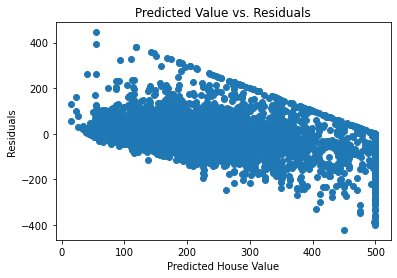

In [ ]:
residuals = y_test['median_house_value(in 1000s)'] - y_d_hat
plt.scatter(y_d_hat, residuals)
plt.title('Predicted Value vs. Residuals')
plt.xlabel('Predicted House Value')
plt.ylabel('Residuals')
plt.show()

### Random Forest

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
rf.score(x_train, y_train)

C:\Users\ashri\AppData\Local\Temp\ipykernel_11568\220325213.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


0.974569804937832

In [ ]:
y_r_hat = rf.predict(x_test)
print(np.sqrt(mean_squared_error(y_test, y_r_hat)))
print(r2_score(y_test, y_r_hat))

49.699192479092744
0.8147358564084628


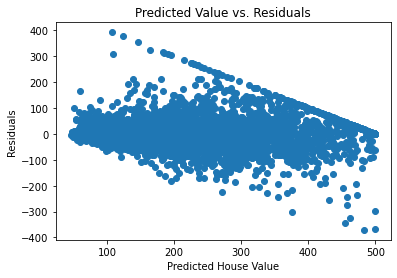

In [ ]:
residuals = y_test['median_house_value(in 1000s)'] - y_r_hat
plt.scatter(y_r_hat, residuals)
plt.title('Predicted Value vs. Residuals')
plt.xlabel('Predicted House Value')
plt.ylabel('Residuals')
plt.show()

#### Cross validating Random Forest Regressor

In [ ]:
def Cross_Val(reg,training_X, training_Y):
    
    cv=RepeatedKFold(n_splits=10, n_repeats=3,random_state=123)
    n_scores = cross_val_score(reg, training_X, training_Y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    n_scores = absolute(n_scores)

    #Report performance
    print("RF Regressor MSE: %.3f" % (n_scores.mean()))
    print(n_scores)

### Hyperparameter tuning for RF

In [ ]:
hyperparameter_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 40, 70, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    }

random_cv = RandomizedSearchCV(estimator=rf,param_distributions=hyperparameter_grid, cv=5, n_iter=50,
            scoring='neg_mean_squared_error',n_jobs =-1,verbose = 5, return_train_score = True,
            random_state=123)

random_cv.fit(x_train,y_train)

best_random = random_cv.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\ashri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
random_cv.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

### Tuned Hyperparameter for Random Forest

In [ ]:
regressor=RandomForestRegressor(bootstrap=False, max_depth=100, max_features='sqrt', min_samples_split=5, min_samples_leaf = 1)
regressor.fit(x_train,y_train)
regressor.score(x_train, y_train)

C:\Users\ashri\AppData\Local\Temp\ipykernel_11568\155243204.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x_train,y_train)


0.9868409699862712

In [ ]:
y_r_hat = regressor.predict(x_test)
print(np.sqrt(mean_squared_error(y_test, y_r_hat)))
print(r2_score(y_test, y_r_hat))

47.71701182841079
0.8292191436796239


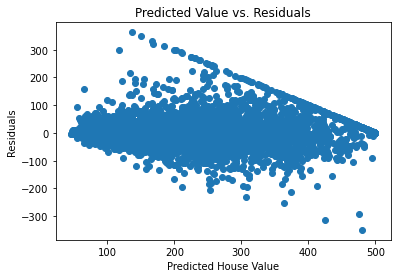

In [ ]:
residuals = y_test['median_house_value(in 1000s)'] - y_r_hat
plt.scatter(y_r_hat, residuals)
plt.title('Predicted Value vs. Residuals')
plt.xlabel('Predicted House Value')
plt.ylabel('Residuals')
plt.show()

### Optimizing hyperparameters

In [ ]:
hyperparameter_grid1 = {
    'bootstrap': [False],
    'max_depth': [110, 100, 80,90],
    'max_features': ['sqrt'],
    'min_samples_split' : [5]
    }

random_cv = RandomizedSearchCV(estimator=rf,param_distributions=hyperparameter_grid1, cv=5, n_iter=50,
            scoring='neg_mean_absolute_error',n_jobs =-1,verbose = 5, return_train_score = True,
            random_state=123)

random_cv.fit(x_train,y_train)

new_best_random = random_cv.best_estimator_

C:\Users\ashri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\ashri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
new_best_params = random_cv.best_params_
new_best_params

{'min_samples_split': 5,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

### Hyperparameter Tuning with XGB

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
reg3 = xgb.XGBRegressor()
Cross_Val(reg3, x_train, y_train)

hyperparameter_grid = {
    'n_estimators': [196],
    'gamma': [0.05,0.1,0.01],
    'max_depth': [3, 8, 10],
    'learning_rate': [0.2, 0.1, 0.05],
    'reg_lambda' : [0,1]
    }

random_cv = RandomizedSearchCV(estimator=reg3,param_distributions=hyperparameter_grid, cv=5, n_iter=50,
            scoring='neg_mean_absolute_error',n_jobs =-1,verbose = 5, return_train_score = True,
            random_state=123)

random_cv.fit(x_train,y_train)

random_cv.best_estimator_


RF Regressor MSE: 2238.438
[2070.08634856 2292.2768518  2366.66394188 2295.10520883 1998.46093893
 2383.24710223 2125.25508473 2275.71640453 2374.13883923 2348.14265376
 2184.29090653 2250.57961446 2448.13505555 2159.39422666 2377.26648295
 2164.36016974 2167.29816557 2100.85995061 2014.64475612 2285.36939816
 2089.24290676 2123.76958262 2325.43411668 2330.87186786 2452.42182898
 2217.27626563 2518.81763224 2194.94532381 2078.24481418 2140.83593006]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=196, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
best_params = random_cv.best_params_
best_params

{'reg_lambda': 1,
 'n_estimators': 196,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 0.1}

### Tuned Hyperparameter Best Model XGB

In [ ]:
import xgboost as xgb
xg = xgb.XGBRegressor(reg_lambda = 1, n_estimators = 196, max_depth = 8, learning_rate = 0.1, gamma = 0.01)
xg.fit(x_train, y_train)
xg.score(x_train, y_train)

0.9594043117259483

In [ ]:
y_x_hat = xg.predict(x_test)
print(np.sqrt(mean_squared_error(y_test, y_x_hat)))
print(r2_score(y_test, y_x_hat))

46.05546414081448
0.8409055478515192


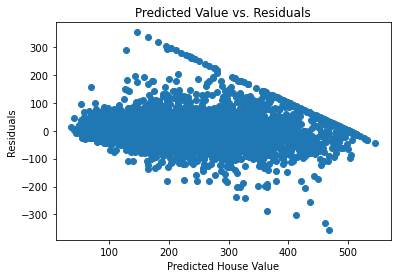

In [ ]:
residuals = y_test['median_house_value(in 1000s)'] - y_x_hat
plt.scatter(y_x_hat, residuals)
plt.title('Predicted Value vs. Residuals')
plt.xlabel('Predicted House Value')
plt.ylabel('Residuals')
plt.show()

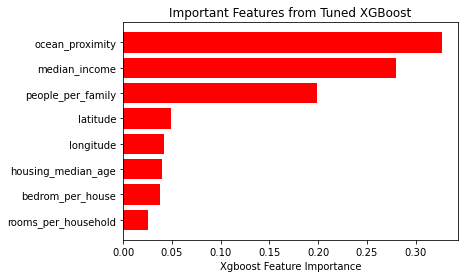

In [ ]:
sorted_idx = xg.feature_importances_.argsort()
plt.barh(features.columns[sorted_idx], xg.feature_importances_[sorted_idx],color = 'red')
plt.xlabel("Xgboost Feature Importance")
plt.title('Important Features from Tuned XGBoost')
plt.show()